Logistic regression

## What IS NOT a logistic regression?

Logistic regression is not:

- a fit of a sigmoid curve to a set of points $(x_1, y_1), ..., (x_n, y_n)$
- a classification method - although it is often used for this purpose

## What IS a logistic regression?

Logistic regression is a regression model that returns a probability of a binary outcome (0 or 1), assuming that log of the odds-ratio is a linear combination of one or more inputs. Odds ratio is ratio between probability of outcome happening (1) and the probability of the outcome not happening (0).

The goal behind logistic regression is to model cases when the input(s) are affecting the outcome in a probabilistic way. This outcome probability is assumed to be an S-shaped curve that can be expressed with the following mathematical equation:

$$
p(x) = \frac{1}{1 + e^{-k(x - x_0)}}
$$ 


## Logistic curve

Let us plot the curve first, for example with $x_0 = 2.5$ and $k = 3$:

In [129]:
import numpy as np
import pandas as pd
import plotnine as p9

from scipy.stats import uniform, bernoulli

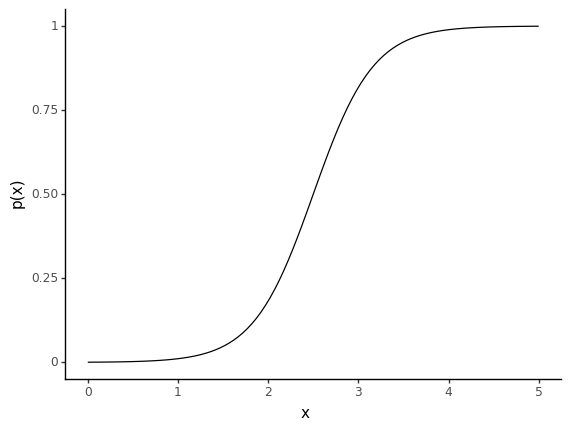

<ggplot: (8760253063518)>

In [130]:
def logistic(x, k, x0):
    return 1 / (1 + np.exp(-k*(x - x0)))

def create_smooth_logistic_curve_data(k, x0, n_points=100):
    df = pd.DataFrame({
        'x': np.linspace(0, 5, n_points)
    })
    df['p_x'] = logistic(df['x'], k, x0)
    return df

def plot_smooth_logistic_curve(k, x0, n_points=100):
    df = create_smooth_logistic_curve_data(k, x0, n_points)
    return (
        p9.ggplot(df, p9.aes('x', 'p_x'))
	    + p9.geom_line()
        + p9.scale_y_continuous(name='p(x)')
        + p9.theme_classic()
    )

plot_logistic_curve(3, 2.5)

The meaning of these two parameters is:
- $x_0$ is the value of a predictor x for which the probability is 0.5 (mid-point): $p(x = x_0) = 0.5$, so tells us about the location of the mid-point.
- $k$ is related to the slope of the probability at that point: $(dp/dx)_{x = x_0} = k/4$, so tells us about the steepness of the curve at that mid-point. The larger the $k$, the steeper the curve.

## Fitting procedure

As mentioned earlier, the fitting process in logistic regression is different than in linear regression. In linear regression, ordinary least square approach takes _vertical differences between the predicted line and data points_ (residuals), squares them, then adds them up.

What if we tried the same here anyway?

Let us add some points to the previous plot to see if this would work or make sense here:

In [131]:
def create_sample_data(k, x0, n_points, seed=1):
    np.random.seed(seed)
    df = pd.DataFrame({
        'x': uniform.rvs(loc=0, scale=5, size=n_points)
    }).sort_values('x', ignore_index=True)
    df['p_x'] = logistic(df['x'], k, x0)
    df['y'] = bernoulli.rvs(df['p_x'])
    return df

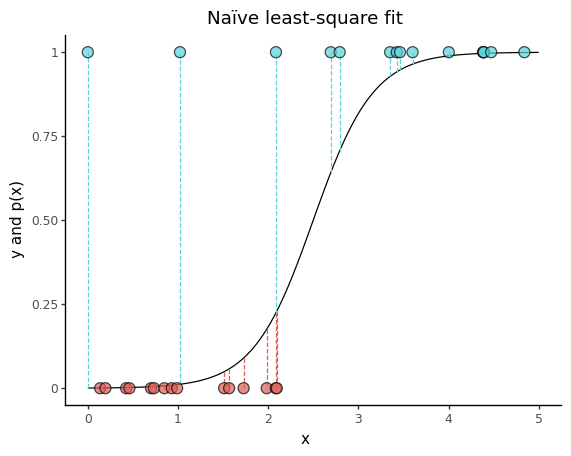

<ggplot: (8760253032822)>

In [132]:
def plot_naive_logistic_fit(k, x0, n_data_points):
    sample_df = create_sample_data(k, x0, n_data_points)
    sample_df.loc[0, 'y'] = 1 # manually add an outlier
    curve_df = create_smooth_logistic_curve_data(k, x0)
    return (
        p9.ggplot(sample_df, p9.aes('x'))
	    + p9.geom_line(
            data=curve_df,
            mapping=p9.aes(y='p_x')
        )
        + p9.geom_linerange(
            mapping=p9.aes(ymin='p_x', ymax='y', color='factor(y)'),
            linetype='dashed'
        )
        + p9.geom_point(
            mapping=p9.aes(y='y', fill='factor(y)'),
            size=4,
            alpha=0.7,
            shape='o'
        )
        + p9.scale_y_continuous(name='y and p(x)')
        + p9.labels.ggtitle('Naïve least-square fit')
        + p9.theme_classic()
        + p9.theme(legend_position='none')
    )

plot_naive_logistic_fit(3, 2.5, n_data_points=30)

Here, we colored the points at $y = 0$ in <font color="#db5f57">red</font> and points at $y = 1$ in <font color="#57d3db">teal</font>.

One of the immediate problems is that the residual of each point can be at most 1. Because of this, the top 3 points (for y = 1) have almost the same residuals. However, it would make more sense to assign a much larger cost to the first teal point that appears at $x=0$ than to the second one at $x=1.2$.

Then, what is the approach employed by logistic regression?

* For the <font color="#57d3db">teal</font> points at $y=1$, one way to create a (positive) larger cost at $x=0$ is to take the (negative) logarithm of the fitted probability, $-\log p(x)$.
* For the <font color="#db5f57">red</font> points at $y=0$ we can do the same for the inverted probability, $-\log[1-p(x)]$.

We will call these "log-losses" - for each point $x$ they give us a *cost* of that point being away from the fitted curve. In order to utilize NumPy vectorization, we will code these two together as a single loss function:

$$
\text{log-loss} = -y\log p(x) - (1-y)\log[1 - p(x)]
$$

* When $y=0$, the first term is zero and the log-loss is equal to $-\log[1 - p(x)]$.
* When $y=1$, the second term is zero, and the log-loss is $-\log p(x)$.

So writing this way is the same as specifying separate functions for each $y$. This combo expression is also called "cross-entropy" and has an another interpretation in information theory that we will not go into at the moment.

Logistic model fits these two functions simultaneously: $-\log p(x)$ for $y=1$ and $-\log[1 - p(x)]$ for $y=0$. We will collapse all the data points to $y=0$ and plot each of these log-losses separately, to get a better intuition what is happening.

As an example, we will again generate 30 data points, with $k=3$ and $x_0=2.5$ and fit them to the log-losses with same parameters for the illustrative purposes:

In [133]:
def log_loss(p_x, y):
    return -y * np.log(p_x) - (1 - y) * np.log(1 - p_x)

In [134]:
def create_smooth_logloss_data(k, x0, n_points=100):
	x = np.linspace(0, 5, n_points)
	p_x = logistic(x, k, x0)
	return pd.DataFrame({
		'x': np.concatenate((
			x,
			x
		)),
		'y': np.concatenate((
			[0] * len(x),
			[1] * len(x)
		)),
		'log_loss': np.concatenate((
			log_loss(p_x, 0),
			log_loss(p_x, 1)
		)),
	})

In [149]:
def plot_logistic_fit(df, logloss_df):
	return (
		p9.ggplot(df, p9.aes('x'))
		+ p9.geom_line(
			data=logloss_df,
			mapping=p9.aes(y='log_loss', color='factor(y)'),
		)
		+ p9.geom_linerange(
		    mapping=p9.aes(ymin=0, ymax='log_loss', color='factor(y)'),
		    linetype='dashed',
		)
		+ p9.geom_point(
			mapping=p9.aes(y=0, fill='factor(y)'),
			size=4,
			alpha=0.7,
			shape='o',
		)
		+ p9.scale_y_continuous(name='log loss')
		# + p9.labels.ggtitle("Total log-loss: " + str(np.sum(df['log_loss'])))
		+ p9.theme_classic()
		+ p9.theme(legend_position='none')		
	)

def create_sample_and_logloss_data(k, x0, k_fit, x0_fit, n_points):
	df = create_sample_data(k, x0, n_points)
	df['p_x_fit'] = logistic(df['x'], k_fit, x0_fit)
	df['log_loss'] = log_loss(df['p_x_fit'], df['y'])
	logloss_df = create_smooth_logloss_data(k_fit, x0_fit)
	return (df, logloss_df)

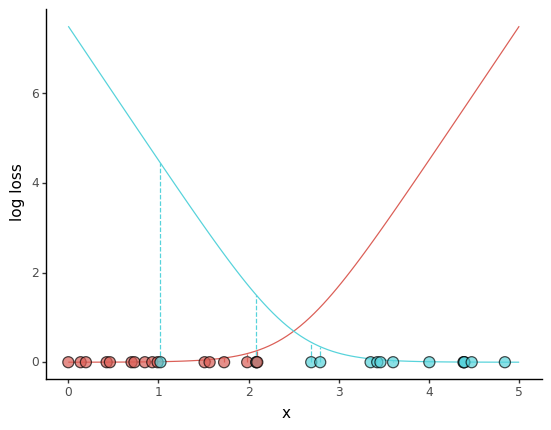

<ggplot: (8760252825007)>

In [150]:
df, logloss_df = create_sample_and_logloss_data(
	k=3,
	x0=2.5,
	k_fit=3,
	x0_fit=2.5,
	n_points=30,
)

plot_logistic_fit(df, logloss_df)

The fitting process is:

* <font color="#db5f57">Red points</font> ($y=0$) are fit to the <font color="db5f57">red "hockey stick" curve</font>: $-\log[1-p(x)]$
* <font color="#57d3db">Teal points</font> ($y=1$) are fit to the <font color="#57d3db">teal "hockey stick" curve</font>: $-\log p(x)$
* Both of these curves share the same parameters $k$ and $x_0$, so they change together
* Sum of the vertical displacements between points is the total cost (or log-loss) that needs to be minimzed for various combinations of $k$ and $x_0$

How does changing $k$ and $x_0$ affect this fit?

In [136]:
params = {
    'x0': [1.5, 2.5, 3.5] + [2.5, 2.5, 2.5],
    'k': [3, 3, 3] + [1, 3, 7]
}

def create_sample_and_logloss_data_from_params(params):
    df_list = []
    logloss_df_list = []
    for x0, k in zip(params['x0'], params['k']):
        df, logloss_df = create_sample_and_logloss_data(
            k=3,
            x0=2.5,
            k_fit=k,
            x0_fit=x0,
            n_points=30
        )
        df['x0_fit'] = logloss_df['x0_fit'] = x0
        df['k_fit'] = logloss_df['k_fit'] = k
        df_list.append(df)
        logloss_df_list.append(logloss_df)

    dfs = pd.concat(df_list, ignore_index=True)
    logloss_dfs = pd.concat(logloss_df_list, ignore_index=True)
    return (dfs, logloss_dfs)

First, we can check that changing $x_0$ again just moves the intersection point left or right:

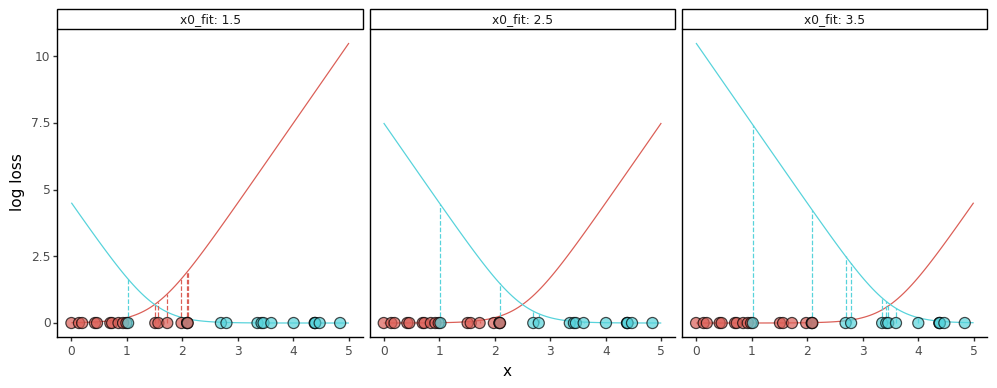

<ggplot: (8760250530669)>

In [155]:
dfs, logloss_dfs = create_sample_and_logloss_data_from_params({
    'x0': [1.5, 2.5, 3.5],
    'k': [3, 3, 3]
})

logistic_fit_plot = plot_logistic_fit(dfs, logloss_dfs)
logistic_fit_plot += p9.facet_wrap('~x0_fit', labeller='label_both') 
logistic_fit_plot += p9.theme(figure_size=(12, 4))
logistic_fit_plot

Next, notice that changing $k$ changes the sharpness of the "hockey stick" log-loss curves (note the y axis span in each plot):

/home/igor/.cache/pypoetry/virtualenvs/blog--v8k-B20-py3.8/lib/python3.8/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


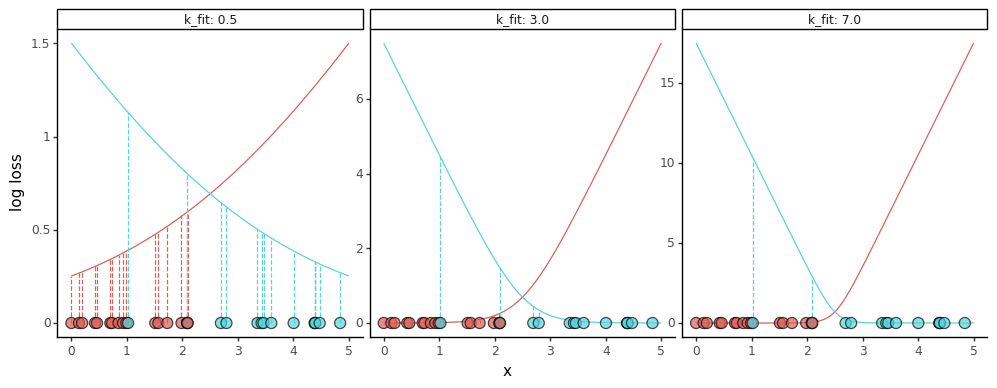

<ggplot: (8760250309364)>

In [158]:
dfs, logloss_dfs = create_sample_and_logloss_data_from_params({
    'x0': [2.5, 2.5, 2.5],
    'k': [0.5, 3, 7]
})

logistic_fit_plot = plot_logistic_fit(dfs, logloss_dfs)
logistic_fit_plot += p9.facet_wrap('~k_fit', labeller='label_both', scales='free_y') 
logistic_fit_plot += p9.theme(figure_size=(12, 4))
logistic_fit_plot

* If $k$ is too low (0.5), the log-loss looks almost linear. Most points have add a small but significant amount to the total log-loss. 
* If $k$ is too high (7), most points on the "correct side" of $x = 2.5$ add a negligible amount to the total log-loss but the  